In [15]:
import pandas as pd
import numpy as np
import random

- O gvns implementado percorre um laço externo (while it < max_iter) e, dentro dele, um laço sobre todas as vizinhanças k = 1..kmax.

- Em cada passo, ele executa:

1. shake → gera uma nova solução.

2. rvnd → que, por sua vez, faz uma busca local explorando vizinhanças até não haver mais melhorias.

O problema é que:

- Dentro de rvnd, você usa first_improvement que percorre toda a vizinhança até achar uma melhora.

- Para instâncias grandes (como o TSP de 250 cidades), cada vizinhança tem tamanho O(n²) (swap, 2-opt, or-opt).

- Isso significa que cada iteração do GVNS pode estar explorando milhões de soluções vizinhas.

Mesmo que no teste você tenha posto max_iter = 1, a rvnd ainda pode rodar várias vezes internamente até atingir ótimo local — e isso sozinho já é muito caro

In [16]:
class Problema:
    def __init__(self, arquivo_distancia, arquivo_tempo):
        self.distancia = pd.read_csv(arquivo_distancia, header=None).to_numpy(dtype=float)
        self.tempo     = pd.read_csv(arquivo_tempo,     header=None).to_numpy(dtype=float)
        self.n = self.distancia.shape[0]  # número de cidades

    def custo_arco(self, i, j, objetivo):
        # objetivo: "distancia" ou "tempo"
        if objetivo == "distancia":
            return self.distancia[i, j]
        else:
            return self.tempo[i, j]

def custo_rota(problema, rota, objetivo) -> int:
    # Soma o custo ao longo da rota circular (0 -> ... -> 0)
    c = 0.0
    for k in range(len(rota) - 1):
        c += problema.custo_arco(rota[k], rota[k+1], objetivo)
    c += problema.custo_arco(rota[-1], rota[0], objetivo)  # volta à origem
    return c



### Heurística construtiva

In [17]:
def construtiva_vizinho_mais_proximo(problema, objetivo) -> list:
    # Gera uma rota inicial simples: vizinho mais próximo a partir da cidade 0.
    n = problema.n
    rota = [0]
    visitado = [False] * n
    visitado[0] = True
    atual = 0

    for cidade in range(n - 1):  # repetimos n-1 escolhas 
        proxima_cidade = None
        menor_custo = float("inf")

        for j in range(n):
            if not visitado[j]:
                custo = problema.custo_arco(atual, j, objetivo)
                if custo < menor_custo:
                    menor_custo = custo
                    proxima_cidade = j

        rota.append(proxima_cidade)
        visitado[proxima_cidade] = True
        atual = proxima_cidade

    return rota

def main():
    problema = Problema("distancia.csv", "tempo.csv")

    # escolha qual função objetivo otimizar nesta execução
    objetivo = "distancia"  # "distancia" ou "tempo"

    # rota inicial (vizinho mais próximo)
    rota = construtiva_vizinho_mais_proximo(problema, objetivo)
    # custo da rota
    c = custo_rota(problema, rota, objetivo)

    print(f"n = {problema.n}")
    print(f"Objetivo: {objetivo}")
    print(f"Custo da rota inicial: {c:.3f} Km")
    print(f"Rota (primeiros 10 nós): {rota[:10]}")

main()

n = 250
Objetivo: distancia
Custo da rota inicial: 1586.700 Km
Rota (primeiros 10 nós): [0, 72, 214, 248, 33, 120, 22, 11, 169, 51]


### Definição das vizinhanças

In [18]:

# ------------------- Vizinhanças (definições corretas) -------------------

MAX_EVALS = 5000

def vizinhanca_swap(rota, a, b):
    """Swap entre posições a e b (não altera posição 0)."""
    if a == 0 or b == 0 or a == b:
        return rota[:]
    n = len(rota)
    if not (0 <= a < n and 0 <= b < n):
        return rota[:]
    nova = rota.copy()
    nova[a], nova[b] = nova[b], nova[a]
    return nova

def vizinhanca_oropt1(rota, a, b):
    """
    Remove o elemento na posição a e insere antes da posição b.
    Se b == n, insere no fim (equivale a inserir antes de rota[0] no ciclo).
    """
    n = len(rota)
    if a == 0 or b == 0 or a == b or b == a+1:
        return rota[:]
    if not (0 <= a < n and 0 <= b <= n):
        return rota[:]
    nova = rota.copy()
    city = nova.pop(a)
    # ajustar índice de inserção se a < b, pois a remoção diminui índices posteriores
    if b > a:
        insert_idx = b - 1
    else:
        insert_idx = b
    # se b == n, insert_idx == n-1 (append)
    if insert_idx >= len(nova):
        nova.append(city)
    else:
        nova.insert(insert_idx, city)
    return nova

def vizinhanca_2opt(rota, a, b):
    """Aplica 2-opt invertendo o segmento entre a e b (inclusive)."""
    n = len(rota)
    if a == 0 or b == 0 or a >= b:
        return rota[:]
    if not (0 <= a < n and 0 <= b < n):
        return rota[:]
    nova = rota[:a] + rota[a:b+1][::-1] + rota[b+1:]
    return nova

def aplicar_vizinhanca(rota, k, a, b):
    """Aplica a vizinhança k sobre (a,b): k=1 swap, k=2 or-opt1, k=3 2-opt."""
    if k == 1:
        return vizinhanca_swap(rota, a, b)
    elif k == 2:
        return vizinhanca_oropt1(rota, a, b)
    elif k == 3:
        return vizinhanca_2opt(rota, a, b)
    else:
        return rota[:]

# ------------------- Deltas (avaliação incremental) -------------------
def diferenca_custo_k1(problema, rota, a, b, objetivo, M=None):
    """
    Delta para SWAP entre posições a < b.
    Retorna novo - antigo (positivo = piora, negativo = melhora).
    """
    n = len(rota)
    if a == 0 or b == 0 or a >= b:
        return 0.0
    if M is None:
        M = problema.distancia if objetivo == "distancia" else problema.tempo
    A_prev = rota[a-1]; A = rota[a]; A_next = rota[a+1] if a+1 < n else rota[0]
    B_prev = rota[b-1]; B = rota[b]; B_next = rota[b+1] if b+1 < n else rota[0]
    if a+1 == b:
        # adjacentes: A_prev - A - B - B_next  -> A_prev - B - A - B_next
        antigo = M[A_prev, A] + M[A, B] + M[B, B_next]
        novo   = M[A_prev, B] + M[B, A] + M[A, B_next]
    else:
        antigo = M[A_prev, A] + M[A, A_next] + M[B_prev, B] + M[B, B_next]
        novo   = M[A_prev, B] + M[B, A_next] + M[B_prev, A] + M[A, B_next]
    return novo - antigo

def diferenca_custo_k2(problema, rota, a, b, objetivo, M=None):
    """
    Delta para OR-OPT(1): remove elemento em a e insere antes de b.
    Condições inválidas retornam 0.
    """
    n = len(rota)
    if a == 0 or b == 0 or b == a or b == a+1:
        return 0.0
    if M is None:
        M = problema.distancia if objetivo == "distancia" else problema.tempo
    Ai = rota[a]
    pred_a = rota[a-1]
    suc_a = rota[a+1] if a+1 < n else rota[0]
    # handle position b possibly equal to n (insert at end / before rota[0])
    if b >= n:
        pred_b = rota[-1]
        b_node = rota[0]
    else:
        pred_b = rota[b-1]
        b_node = rota[b]
    antigo = M[pred_a, Ai] + M[Ai, suc_a] + M[pred_b, b_node]
    novo   = M[pred_a, suc_a] + M[pred_b, Ai] + M[Ai, b_node]
    return novo - antigo

def diferenca_custo_k3(problema, rota, a, b, objetivo, M=None):
    """
    Delta para 2-opt: inverter segmento entre a..b
    """
    n = len(rota)
    if a == 0 or b == 0 or a >= b:
        return 0.0
    if M is None:
        M = problema.distancia if objetivo == "distancia" else problema.tempo
    a_prev = rota[a-1]
    b_node = rota[b]
    b_next = rota[b+1] if b+1 < n else rota[0]
    antigo = M[a_prev, rota[a]] + M[b_node, b_next]
    novo   = M[a_prev, b_node] + M[rota[a], b_next]
    return novo - antigo

# ------------------- First-improvement (varredura por vizinhança) -------------------
def first_improvement(problema, rota, objetivo, k, max_evals=MAX_EVALS):
    """Procura e retorna o primeiro vizinho que melhora (first-improvement) na vizinhança k."""
    n = len(rota)
    custo = custo_rota(problema, rota, objetivo)
    evals = 0
    if k == 1:
        for a in range(1, n-1):
            for b in range(a+1, n):
                delta = diferenca_custo_k1(problema, rota, a, b, objetivo)
                evals += 1
                if delta < -1e-12:
                    return vizinhanca_swap(rota, a, b), custo + delta
                if evals >= max_evals:
                    return rota, custo
    elif k == 2:
        for a in range(1, n-1):
            for b in range(1, n+1):
                if b == a or b == a+1:
                    continue
                delta = diferenca_custo_k2(problema, rota, a, b, objetivo)
                evals += 1
                if delta < -1e-12:
                    return vizinhanca_oropt1(rota, a, b), custo + delta
                if evals >= max_evals:
                    return rota, custo
    elif k == 3:
        for a in range(1, n-2):
            for b in range(a+1, n):
                delta = diferenca_custo_k3(problema, rota, a, b, objetivo)
                evals += 1
                if delta < -1e-12:
                    return vizinhanca_2opt(rota, a, b), custo + delta
                if evals >= max_evals:
                    return rota, custo
    return rota, custo

# ------------------- Neighborhood change -------------------
def neighborhood_change(rota, custo, rota_cand, custo_cand, k):
    if custo_cand < custo - 1e-12:
        return rota_cand, custo_cand, 1
    else:
        return rota, custo, k + 1

# ------------------- RVND -------------------
def rvnd(problema, rota_inicial, objetivo, seed=None, max_evals=MAX_EVALS):
    if seed is not None:
        random.seed(seed)
    rota = rota_inicial[:]
    custo = custo_rota(problema, rota, objetivo)
    Ks = [1, 2, 3]
    while True:
        lista = Ks[:]
        random.shuffle(lista)
        melhorou = False
        
        for k in lista:
            rota_cand, custo_cand = first_improvement(problema, rota, objetivo, k)
            if custo_cand < custo - 1e-12:
                rota, custo = rota_cand, custo_cand
                melhorou = True
                break
        if not melhorou:
            break
    return rota, custo

# ------------------- Shaking -------------------
def shake(rota, k):
    n = len(rota)
    if k == 1:
        a = random.randrange(1, n-1)
        b = random.randrange(a+1, n)
        return vizinhanca_swap(rota, a, b)
    elif k == 2:
        a = random.randint(1, n-2)
        b = random.randint(1, n)
        if b == a or b == a+1:
            b = (b + 2) % n
            if b == 0: b = 1
        return vizinhanca_oropt1(rota, a, b)
    elif k == 3:
        a = random.randint(1, n-3)
        b = random.randint(a+1, n-1)
        return vizinhanca_2opt(rota, a, b)
    else:
        nova = rota.copy()
        for _ in range(min(5, n-1)):
            i = random.randint(1, n-1)
            j = random.randint(1, n-1)
            nova[i], nova[j] = nova[j], nova[i]
        return nova

# ------------------- GVNS -------------------
def gvns(problema, rota_inicial, objetivo, kmax=3, max_iter=1000, seed=None, max_evals_rvnd=MAX_EVALS):
    if seed is not None:
        random.seed(seed)
    x = rota_inicial[:]
    fx = custo_rota(problema, x, objetivo)
    it = 0
    solutions = []
    while it < max_iter:
        k = 1
        while k <= kmax and it < max_iter:
            x_pr = shake(x, k)
            x_b, f_b = rvnd(problema, x_pr, objetivo, seed=None)
            x, fx, k = neighborhood_change(x, fx, x_b, f_b, k)
            it += 1
        solutions.append((it, fx))
    return x, fx, solutions


n = 250
Objetivo: distancia
Custo rota inicial (NN): 1586.700 Km
Custo após GVNS:        1462.900 Km


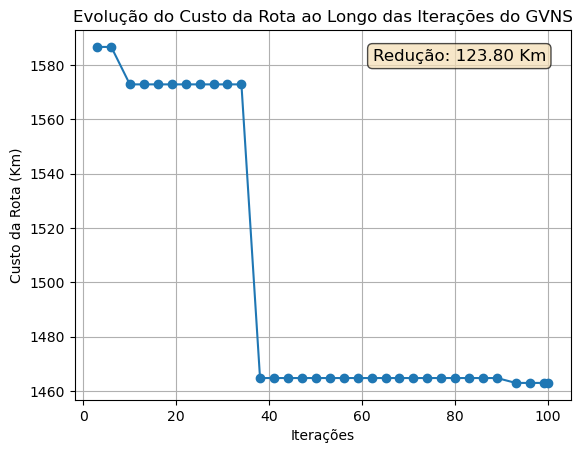

n = 250
Objetivo: distancia
Custo rota inicial (NN): 1586.700 Km
Custo após GVNS:        1385.400 Km


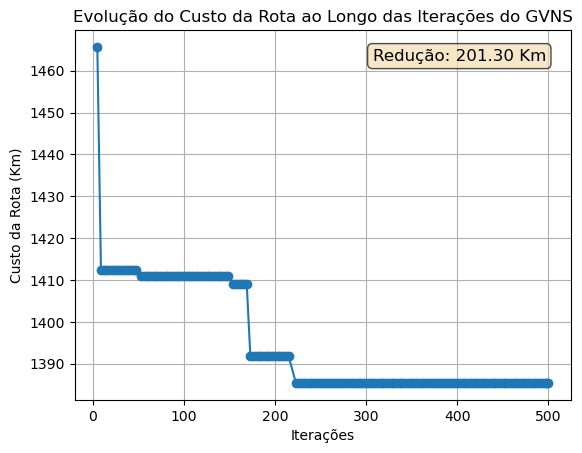

n = 250
Objetivo: distancia
Custo rota inicial (NN): 1586.700 Km
Custo após GVNS:        1377.900 Km


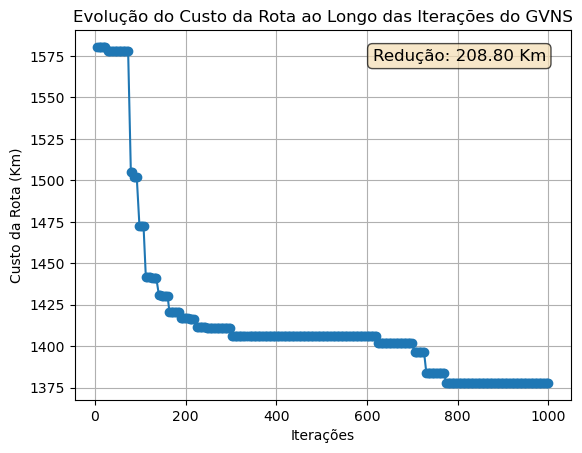

n = 250
Objetivo: distancia
Custo rota inicial (NN): 1586.700 Km
Custo após GVNS:        1262.200 Km


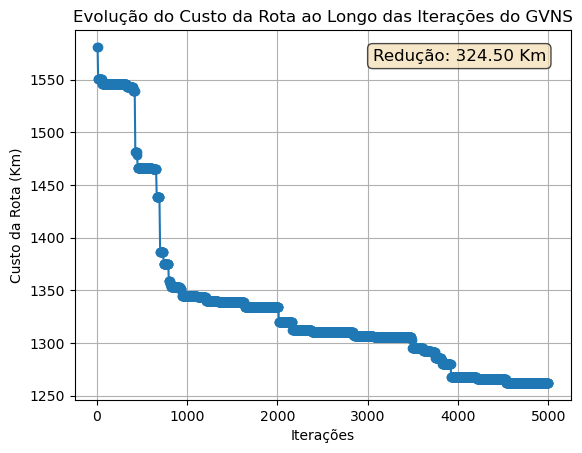

KeyboardInterrupt: 

In [ ]:
def run_gvns_experiment(problema, objetivo, kmax=3, max_iter=1000, max_evals_rvnd=500, plot=True):
    # rota inicial por Vizinho Mais Próximo
    rota0 = construtiva_vizinho_mais_proximo(problema, objetivo)
    c0 = custo_rota(problema, rota0, objetivo)

    # roda o GVNS
    rota_g, c_g, solutions = gvns(
        problema, rota0, objetivo,
        kmax=kmax,
        max_iter=max_iter,
        max_evals_rvnd=max_evals_rvnd
    )

    print(f"n = {problema.n}")
    print(f"Objetivo: {objetivo}")
    print(f"Custo rota inicial (NN): {c0:.3f} Km")
    print(f"Custo após GVNS:        {c_g:.3f} Km")

    if plot:
        import matplotlib.pyplot as plt
        its, costs = zip(*solutions)
        plt.plot(its, costs, marker='o')
        plt.xlabel('Iterações')
        plt.ylabel('Custo da Rota (Km)')
        plt.title('Evolução do Custo da Rota ao Longo das Iterações do GVNS')
        diff = c0 - c_g
        textstr = f'Redução: {diff:.2f} Km'
        plt.gca().text(0.95, 0.95, textstr, transform=plt.gca().transAxes,
                   fontsize=12, verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
        plt.grid()
        plt.show()
    
    return {
        'rota_inicial': rota0,
        'custo_inicial': c0,
        'rota_gvns': rota_g,
        'custo_gvns': c_g,
        'solutions': solutions
    }

run_gvns_experiment(problema, objetivo="distancia", kmax=3, max_iter=100, max_evals_rvnd=500, plot=True)
run_gvns_experiment(problema, objetivo="distancia", kmax=3, max_iter=500, max_evals_rvnd=500, plot=True)
run_gvns_experiment(problema, objetivo="distancia", kmax=3, max_iter=1000, max_evals_rvnd=700, plot=True)
run_gvns_experiment(problema, objetivo="distancia", kmax=3, max_iter=2000, max_evals_rvnd=1000, plot=True)
run_gvns_experiment(problema, objetivo="distancia", kmax=3, max_iter=5000, max_evals_rvnd=1000, plot=True)
